# NLP Assignment 2: Using LSTM
By Sanskar Jadhav PRN 21070126076 AIML B1

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import string, re, nltk
from string import punctuation
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import spacy
!pip install contractions
import contractions
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 16.5 MB/s eta 0:00:00


## Data Preprocessing

In [ ]:
# saving the dataset in a dataframe
# i'm taking the dataset from my dropbox, so no need to upload to Colab manually
imdb_df = pd.read_csv("https://www.dropbox.com/scl/fi/by1d23shj320pz7wcljb6/IMDB-Dataset.csv?rlkey=448p28vifmtrx38bf24b16ypy&dl=1")
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
imdb_df.shape

(50000, 2)

In [ ]:
# removing null values and duplicates
imdb_df.dropna(inplace = True)
imdb_df.drop_duplicates(inplace = True)
imdb_df.reset_index(drop = True, inplace = True)

In [ ]:
# regular expression tokenization
regexp = RegexpTokenizer("[\w']+")

In [ ]:
# remove punctuation
def remove_punctuation(text):
  punct = string.punctuation
  text = text.translate(str.maketrans("", "", punct))
  return text

In [ ]:
# make text lowercase
def text_lower(text):
  text = text.lower()
  return text

In [ ]:
# remove spaces
def remove_whitespace(text):
  text = text.strip()
  return text

In [ ]:
# remove html tags
def remove_html(text):
  html = re.compile(r'<.*?>')
  text = html.sub(r' ', text)
  return text

In [ ]:
# remove emojis
def remove_emoji(text):
  emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+",flags=re.UNICODE
  )
  text = emoji_pattern.sub(r'', text)
  return text

In [ ]:
# remove URLs
def remove_http_links(text):
  text = re.sub('http://\S+|https://\S+','',text)
  return text

In [ ]:
# replace abbreviated words
abbrev = pd.read_csv('/content/drive/MyDrive/abbrevations.csv', names=['SMF','FF'])
abbrev_lower = pd.DataFrame()
abbrev_lower['SMF'] = abbrev['SMF'].apply(text_lower)
abbrev_lower['FF'] = abbrev['FF'].apply(text_lower)
abbrev_dict = dict(zip(list(abbrev_lower.SMF), list(abbrev_lower.FF)))
abbrev_words = list(abbrev_dict.keys())
# function with regular expression tokenization
def convert_abbrev(text):
  words = []
  for word in regexp.tokenize(text):
    if word in abbrev_words:
      words = words + abbrev_dict[word].split()
    else:
      words = words + word.split()
  text_converted = " ".join(words)
  return text_converted

In [ ]:
# fix contractions
def convert_contractions(text):
  text = contractions.fix(text)
  return text

In [ ]:
# remove stopwords from tokenized text
def remove_stopwords(text):
  text = " ".join([word for word in nltk.tokenize.word_tokenize(text) if word not in stopwords.words('english')])
  return text

In [ ]:
# lemmatization
nlp = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
def lemmatize(text):
  text = " ".join([token.lemma_ for token in nlp(text)])
  #lem = " "
  #for doc in nlp.pipe(text, batch_size=500, n_process=2):
  #  text = " ".join([tok.lemma_ for tok in doc.split(' ')])
  #  lem += text.lower()
  return text

In [ ]:
# aggregating all functions
def text_clean(text):
  text = remove_html(text)
  text = re.sub('\d{4}', ' ', text)
  text = re.sub('\n' , ' ', text)
  text = text_lower(text)
  text = remove_http_links(text)
  text = remove_emoji(text)
  text = remove_whitespace(text)
  text = convert_abbrev(text)
  text = convert_contractions(text)
  text = remove_punctuation(text)
  text = remove_stopwords(text)
  text = lemmatize(text)
  return text

In [ ]:
# example to see code output
eg = imdb_df['review'][:5]
im = eg.apply(text_clean)
print(im)

0    one reviewer mention watch 1 oz episode hook a...
1    wonderful little production filming technique ...
2    think wild guess wonderful way spend time hot ...
3    basically family little boy jake think zombie ...
4    petter matteis love time money visually stunni...
Name: review, dtype: object


In [ ]:
im[0]

'one reviewer mention watch 1 oz episode hook acronym rich environment right exactly happen first thing strike oz wild guess brutality unflinche scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inward significant privacy high agenda email city home many aryan muslims gangstas latinos christians italian irish significant scuffle death stare dodgy dealing shady agreement acronym rich environment never far away would say main appeal show due fact go show would dare forget pretty picture paint mainstream audience forget charm forget romance oz mess around first episode ever see strike significant nasty wild guess surreal could say wild guess ready watch develop taste oz get accustom high level graphic violence violence injustice crook guard sell nickel inmate kill order g

In [ ]:
# apply on imdb review dataset
imdb_df['clean_review'] = imdb_df['review'].apply(text_clean)
imdb_df.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mention watch 1 oz episode hook a...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,think wild guess wonderful way spend time hot ...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


This previous code completed after more than half an hour, so better to save this dataframe as a csv for future reference.

In [ ]:
imdb_df.to_csv('/content/drive/My Drive/cleanreviews.csv', index=False)

# Day 2

In [3]:
df = pd.read_csv('/content/drive/My Drive/cleanreviews.csv')
df.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mention watch 1 oz episode hook a...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,think wild guess wonderful way spend time hot ...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [4]:
df['encodedsentiment'] = [0 if x == 'negative' else 1 for x in df['sentiment']]
df.head()

,review,sentiment,clean_review,encodedsentiment
0,One of the other reviewers has mentioned that ...,positive,one reviewer mention watch 1 oz episode hook a...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,1
2,I thought this was a wonderful way to spend ti...,positive,think wild guess wonderful way spend time hot ...,1
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,1


## Data Splitting

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_review,df.encodedsentiment,stratify=df.encodedsentiment, train_size=0.8, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train,dtype=np.float32)
y_test = np.array(y_test,dtype=np.float32)

## For Set 1

In [6]:
batch_size = 4
max_words = 10000
max_len = 50
embedding_dim = 50
lstm_units = 32

In [7]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
seqs = tok.texts_to_sequences(X_train)
test_seqs = tok.texts_to_sequences(X_test)
seq_matrix = sequence.pad_sequences(seqs,max_len)
test_seq_matrix = sequence.pad_sequences(test_seqs,max_len)

In [8]:
def LSTM_Model(words,len,dim,units,num_labels):
  model = tf.keras.Sequential()
  model.add(Embedding(input_dim=words, output_dim=dim, input_length=len))
  model.add(LSTM(units=units, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(num_labels, activation='softmax'))
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [9]:
model = LSTM_Model(max_words,max_len,embedding_dim,lstm_units,2) # 2 output classes

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            500000    
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 510,690
Trainable params: 510,690
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(seq_matrix,y_train,epochs=3,batch_size=batch_size,validation_split=0.2)

Epoch 1/3
7933/7933 [==============================] - 918s 115ms/step - loss: 0.3935 - accuracy: 0.8233 - val_loss: 0.3607 - val_accuracy: 0.8369
Epoch 2/3
7933/7933 [==============================] - 907s 114ms/step - loss: 0.2775 - accuracy: 0.8832 - val_loss: 0.3623 - val_accuracy: 0.8442
Epoch 3/3
7933/7933 [==============================] - 909s 115ms/step - loss: 0.2149 - accuracy: 0.9130 - val_loss: 0.4174 - val_accuracy: 0.8361


In [12]:
prediction = model.predict(test_seq_matrix)

310/310 [==============================] - 7s 19ms/step


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,np.argmax(prediction, axis=1), target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.83      0.88      0.85      4940
    positive       0.87      0.82      0.85      4977

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



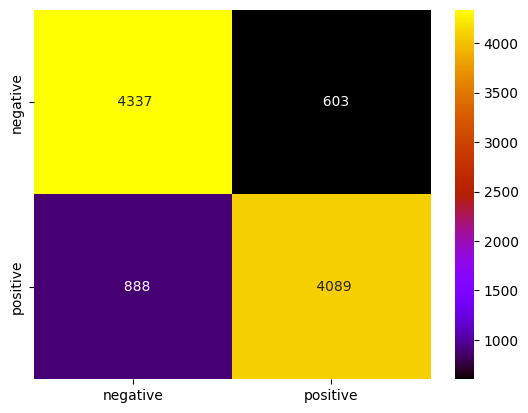

In [18]:
sns.heatmap(confusion_matrix(y_test,np.argmax(prediction, axis=1)),annot=True,fmt='5',cmap='gnuplot',xticklabels=['negative', 'positive'],yticklabels=['negative', 'positive']);

## For Set 2

In [33]:
batch_size = 8
max_words = 25000
max_len = 30
embedding_dim = 30
lstm_units = 32

In [34]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
seqs = tok.texts_to_sequences(X_train)
test_seqs = tok.texts_to_sequences(X_test)
seq_matrix = sequence.pad_sequences(seqs,max_len)
test_seq_matrix = sequence.pad_sequences(test_seqs,max_len)

In [35]:
def LSTM_Model(words,len,dim,units,num_labels):
  model = tf.keras.Sequential()
  model.add(Embedding(input_dim=words, output_dim=dim, input_length=len))
  # This time, 2 layers of LSTM
  model.add(LSTM(units=units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  model.add(LSTM(units=units, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(num_labels, activation='softmax'))
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [36]:
model = LSTM_Model(max_words,max_len,embedding_dim,lstm_units,2)

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 30)            750000    
                                                                 
 lstm_7 (LSTM)               (None, 30, 32)            8064      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 766,450
Trainable params: 766,450
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(seq_matrix,y_train,epochs=3,batch_size=batch_size,validation_split=0.2)

Epoch 1/3
3967/3967 [==============================] - 1411s 354ms/step - loss: 0.4374 - accuracy: 0.7930 - val_loss: 0.4006 - val_accuracy: 0.8167
Epoch 2/3
3967/3967 [==============================] - 1412s 356ms/step - loss: 0.3064 - accuracy: 0.8715 - val_loss: 0.4034 - val_accuracy: 0.8137
Epoch 3/3
3967/3967 [==============================] - 1432s 361ms/step - loss: 0.2278 - accuracy: 0.9081 - val_loss: 0.4597 - val_accuracy: 0.8060


In [39]:
prediction = model.predict(test_seq_matrix)

310/310 [==============================] - 9s 27ms/step


In [40]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,np.argmax(prediction, axis=1), target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.82      0.81      0.81      4940
    positive       0.81      0.82      0.82      4977

    accuracy                           0.82      9917
   macro avg       0.82      0.82      0.82      9917
weighted avg       0.82      0.82      0.82      9917



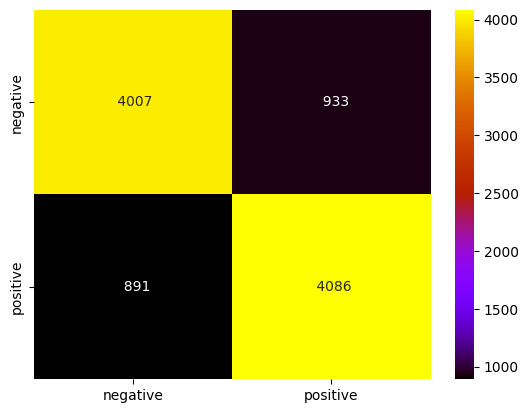

In [41]:
sns.heatmap(confusion_matrix(y_test,np.argmax(prediction, axis=1)),annot=True,fmt='5',cmap='gnuplot',xticklabels=['negative', 'positive'],yticklabels=['negative', 'positive']);

Thus, our first LSTM model with a single layer of 32 units performed slightly better than our second LSTM model with two layers, showcasing an accuracy of 85% > 82%. We can also see that our second LSTM model took more time to fit on the training data. One thing to note is that both models performed fairly similar when classifying true positive reviews. Model 1 did a better job in correctly identifying true negative reviews.